# TUGAS PRAKTIKUM

### 1. Gunakan data 'Mall_Customers.csv''

In [2]:
# Persiapan data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [3]:
# Load data
df = pd.read_csv('Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 2. Tentukan fitur apa yang tepat untuk melakukan clustering (minimal 2)

Fitur yang tepat untuk clustering diantaranya yaitu:
1. Pendapatan Tahunan (Annual Income):
> Pendapatan pelanggan memberikan indikasi tentang kemampuan ekonomi dan potensi pengeluaran mereka. Ini adalah fitur yang sangat penting untuk melakukan clustering pelanggan.
2. Skor Pengeluaran (Spending Score):
> Skor ini mencerminkan seberapa sering atau seberapa besar pelanggan menghabiskan uang di mall. Ini adalah indikator penting dari perilaku belanja pelanggan.

Alasannya karena Pendapatan Tahunan dan Skor Pengeluaran adalah dua fitur numerik yang secara langsung dapat menunjukkan pola belanja yang berbeda pada pelanggan.

Kombinasi kedua fitur ini memungkinkan kita untuk membagi pelanggan ke dalam segmen yang berbeda, misalnya:
* Pelanggan dengan pendapatan tinggi dan skor pengeluaran tinggi,
* Pelanggan dengan pendapatan rendah dan skor pengeluaran rendah, dan seterusnya.

### 3. Buatlah model K-Means dengan mempertimbangkan jumlah k yang terbaik.

In [6]:
X = df.iloc[:,3:]
X.head()


,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [7]:
X.shape

(200, 2)

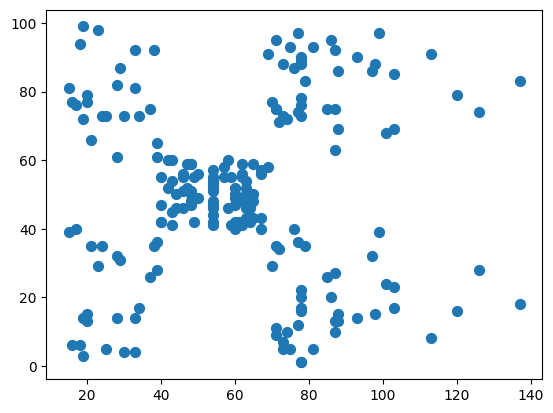

In [8]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s = 50)

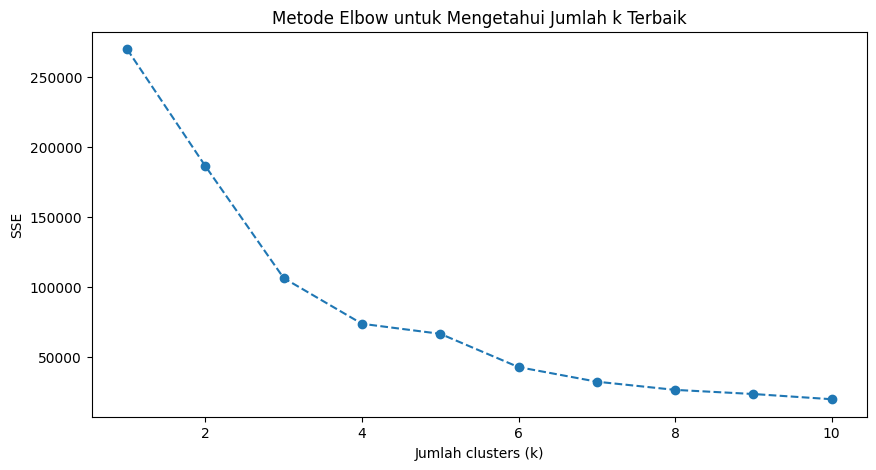

In [18]:
# List untuk menyimpan nilai SSE
sse = []

# Mencari nilai k terbaik dari 1 hingga 10
K = range(1, 11)  # Menentukan range k dari 1 sampai 10

for k in K:
    kmeanModel = KMeans(n_clusters=k)  # Membuat model K-Means dengan k clusters
    kmeanModel.fit(X)  # Melatih model K-Means
    sse.append(kmeanModel.inertia_)

# Visualisasi menggunakan Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, sse, marker='o', linestyle='--')
plt.title('Metode Elbow untuk Mengetahui Jumlah k Terbaik')
plt.xlabel('Jumlah clusters (k)')
plt.ylabel('SSE')
plt.show()


In [10]:
for k in K:
    kmeanModel = KMeans(n_clusters=k)  # Membuat model K-Means dengan k clusters
    kmeanModel.fit(X)  # Melatih model K-Means
    sse.append(kmeanModel.inertia_)
    print(f"Nilai SSE untuk k={k}: {kmeanModel.inertia_}")

Nilai SSE untuk k=1: 269981.28000000014
Nilai SSE untuk k=2: 181363.59595959607
Nilai SSE untuk k=3: 152971.7527504037
Nilai SSE untuk k=4: 73679.78903948837
Nilai SSE untuk k=5: 44448.45544793369
Nilai SSE untuk k=6: 38797.9027638142
Nilai SSE untuk k=7: 30241.34361793659
Nilai SSE untuk k=8: 28707.285166868012
Nilai SSE untuk k=9: 22993.54204424097
Nilai SSE untuk k=10: 19657.783608703947


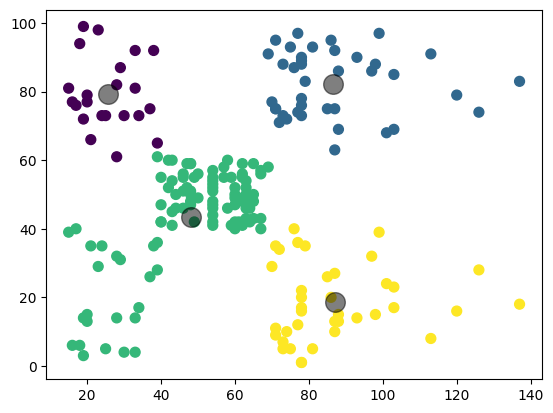

In [11]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [12]:
# Cek Nilai SSE
print(f'Nilai SSE: {kmeans.inertia_}')

Nilai SSE: 73880.64496247198


### 4. Buatlah implementasi model SOM untuk segmentasi citra lain

In [13]:
# Inisialisasi bobot SOM secara acak
def initialize_weights(som_shape):
    return np.random.rand(*som_shape)

# Hitung jarak Euclidean antara input dan bobot SOM
def calculate_distance(input_vector, weights):
    return np.linalg.norm(input_vector - weights, axis=2)

# Cari unit pemenang (neuron terdekat)
def find_winner(input_vector, weights):
    distances = calculate_distance(input_vector, weights)
    return np.unravel_index(np.argmin(distances), distances.shape)

# Perbarui bobot SOM berdasarkan input, pemenang, dan radius tetangga
def update_weights(input_vector, weights, winner, learning_rate, radius):
    som_shape = weights.shape[:2]
    x, y = np.indices(som_shape)

    # Hitung jarak dari unit pemenang ke semua neuron
    distances_to_winner = np.sqrt((x - winner[0])**2 + (y - winner[1])**2)

    # Hitung pengaruh berdasarkan jarak dari pemenang
    influence = np.exp(-distances_to_winner**2 / (2 * (radius**2)))

    # Perbarui bobot
    weights += learning_rate * influence[:, :, np.newaxis] * (input_vector - weights)

# Latih SOM
def train_som(image, num_epochs, learning_rate=0.1, radius=5):
    input_shape = image.shape
    som_shape = (10, 10, input_shape[2])  # Ukuran SOM 10x10 untuk RGB atau grayscale
    weights = initialize_weights(som_shape)

    for epoch in range(num_epochs):
        # Kurangi learning rate dan radius secara bertahap setiap epoch
        current_lr = learning_rate * np.exp(-epoch / num_epochs)
        current_radius = radius * np.exp(-epoch / num_epochs)

        # Latih SOM menggunakan setiap pixel dari citra
        for i in range(input_shape[0]):
            for j in range(input_shape[1]):
                input_vector = image[i, j, :]
                winner = find_winner(input_vector, weights)
                update_weights(input_vector, weights, winner, current_lr, current_radius)

    return weights


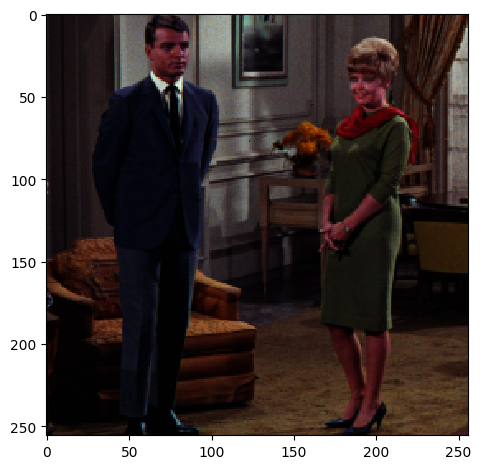

In [19]:
# Load citra
path = "couple.tiff"
original_img = io.imread(path) / 255.0
io.imshow(original_img)

In [22]:
# Latih SOM
trained_weights = train_som(original_img, num_epochs=20, learning_rate=0.1, radius=5)


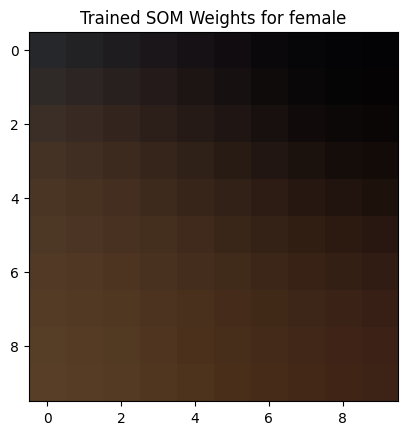

In [21]:
# Visualisasi bobot SOM
plt.imshow(trained_weights)
plt.title('Trained SOM Weights for female')
plt.show()